# Assignment 3: Recurrent Neural Network (RNN) {-}

This assignment aims at familiarizing you with training, validating and testing Recurrent Neural Networks (RNNs). Here are the BASIC requirements of the assignment:

BASIC requirements:
- Load the data.
- Analyze the data.
- Process the data.
- Build a RNN model using GRU (https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) instead of LSTM as in the demo code.
- Train and validate the RNN model (with GRU) to perform the movie review classification.
- Evaluate the performance of the model on the test set.
- Compare the accuracy and the running time between GRU and LSTM.
- Visualize the model behaviour during the training.

EXTRA CREDIT if all of the following requirements are fulfilled:
- Build a RNN model using Bi-LSTM (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Compare the accuracy and the running time between Bi-LSTM and the others (GRU, LSTM).
- Build a RNN model using 1D-Convolution (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Compare the accuracy and the running time between 1D-Convolution and the others (Bi-LSTM, GRU, LSTM).
- Apply transfer learning with the pre-trained word vectors GloVe (https://nlp.stanford.edu/projects/glove/). Observe the accuracy of the model with and without using transfer learning, then give conclusion.

The dataset you will be working on is imdb_reviews. This dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a positive or negative sentiment. Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
- label (tf.int64)
- text (tf.string)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment3-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named DL4AI-\<StudentID>-Assignment3 (e.g., DL4AI-2012345-Assigment3) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. The model accuracy on the test set is one of the most important evaluation criteria. Therefore try to push it as high as possible. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

## Import library

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

# Download tensorflow datasets
!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.layers import GRU, LSTM, Dense, Input, TextVectorization, Embedding, Bidirectional, Conv1D, Flatten, MaxPooling1D

## Load the dataset

In [3]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteH1VL49/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteH1VL49/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteH1VL49/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [4]:
# Show same samples in the training set
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

## Preprocess the dataset

### Train/Val/Test split

In [5]:
dataset_list = [train_dataset, val_dataset, test_dataset]

# Use list comprehension to convert each dataset to numpy arrays of X and y
X, y = zip(*[(np.array([x[0] for x in tfds.as_numpy(dataset)]), 
              np.array([x[1] for x in tfds.as_numpy(dataset)]).astype(np.int16)) 
             for dataset in dataset_list])

# Unpack the resulting list into separate variables
X_train, X_val, X_test = X
y_train, y_val, y_test = y


In [6]:
# Check the shape of 3 datasets
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


### Encode the text

Initialize and build the text vectorizer

In [7]:
### TextVectorization layer maps text features to interger sequences
# Set vocabulary size for the training data
VOCAB_SIZE = 1000 

# Initialize TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation', max_tokens = VOCAB_SIZE)

# Feed training data to adapt() method to calculate the layer's volcabulary
text_encoder.adapt(X_train)

In [8]:
vocab = np.array(text_encoder.get_vocabulary())
print('Vocabulary size: ', vocab.shape)
vocab[:20]

Vocabulary size:  (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Test the vectorizer

In [9]:
# Create a model using TextVectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating explicit input layer with shape (1,) to ensure exactly one string input per batch
model_encoder.add(tf.keras.Input(shape=(1,), dtype = tf.string))

# Adding TextVectorization layer to the model. Output is a tensor of shape(batch_size, max_len)
model_encoder.add(text_encoder)

# Testing with the sample sentences
test_data = [['Deep Learning is fun'], ['Deep Learning is difficult to understand sad']]
model_encoder.predict(test_data)

1/1 [==============================] - 0s 144ms/step


array([[961,   1,   7, 252,   0,   0,   0],
       [961,   1,   7, 833,   6, 375, 627]])

In [10]:
print('Original: ', X_train[0])
print(" ")
print("Round trip: ", " ".join(vocab[text_encoder(X_train[0]).numpy()]))

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 
Round trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK

## Analyze data

Text(0.5, 1.0, 'Number of positive and negative reviews in training set')

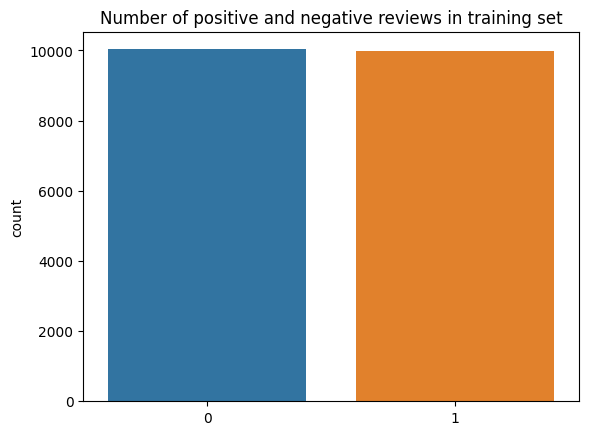

In [11]:
sns.countplot(x=y_train)
plt.title("Number of positive and negative reviews in training set")

Text(0.5, 1.0, 'Number of positive and negative reviews in validation set')

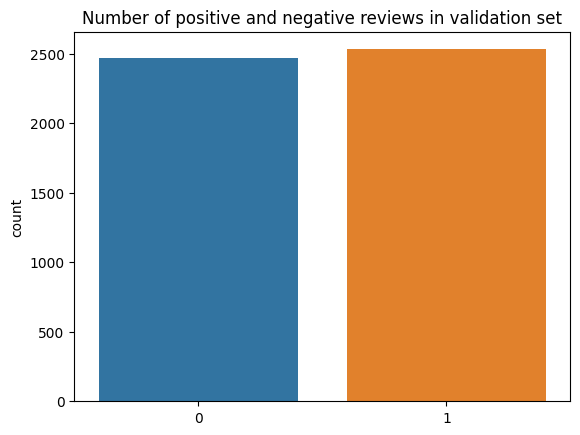

In [12]:
sns.countplot(x=y_val)
plt.title("Number of positive and negative reviews in validation set")

Text(0.5, 1.0, 'Number of positive and negative reviews in testing set')

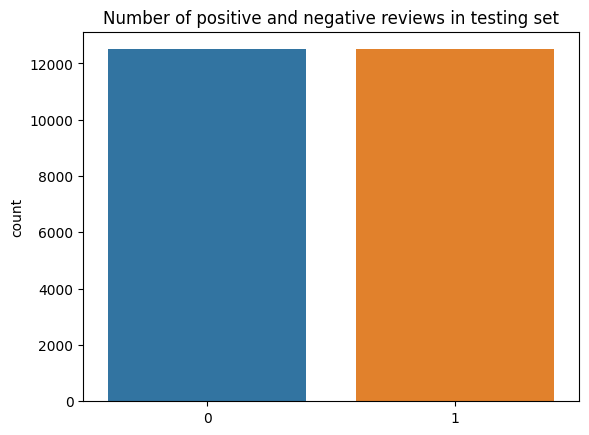

In [13]:
sns.countplot(x = y_test)
plt.title("Number of positive and negative reviews in testing set")

## 1. RNN model with LSTM

### Build the model

In [14]:
# Initialize sequential model with LSTM layer
lstm = tf.keras.models.Sequential([
    text_encoder,
    Embedding(
        input_dim = len(text_encoder.get_vocabulary()) + 1,
        output_dim = 64,
        mask_zero = True),
    LSTM(units=64),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [15]:
# Summarize the model
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64064     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 101,313
Trainable params: 101,313
Non-trainable params: 0
________________________________________________

### Train the model

In [16]:
lstm.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-3), 
              metrics = ['accuracy'])

lstm_history = lstm.fit(X_train, y_train, epochs = 20, batch_size = 2048, validation_data = (X_val, y_val))

Epoch 1/20
10/10 [==============================] - 15s 470ms/step - loss: 0.6919 - accuracy: 0.5370 - val_loss: 0.6888 - val_accuracy: 0.5834
Epoch 2/20
10/10 [==============================] - 3s 320ms/step - loss: 0.6791 - accuracy: 0.6421 - val_loss: 0.6515 - val_accuracy: 0.6974
Epoch 3/20
10/10 [==============================] - 3s 331ms/step - loss: 0.6165 - accuracy: 0.6814 - val_loss: 0.6514 - val_accuracy: 0.5950
Epoch 4/20
10/10 [==============================] - 3s 291ms/step - loss: 0.6277 - accuracy: 0.6626 - val_loss: 0.6149 - val_accuracy: 0.7104
Epoch 5/20
10/10 [==============================] - 3s 284ms/step - loss: 0.6102 - accuracy: 0.6946 - val_loss: 0.6063 - val_accuracy: 0.6860
Epoch 6/20
10/10 [==============================] - 3s 326ms/step - loss: 0.5876 - accuracy: 0.7095 - val_loss: 0.5706 - val_accuracy: 0.7264
Epoch 7/20
10/10 [==============================] - 3s 345ms/step - loss: 0.5471 - accuracy: 0.7352 - val_loss: 0.5193 - val_accuracy: 0.7464
Epoch

### Evaluate the model

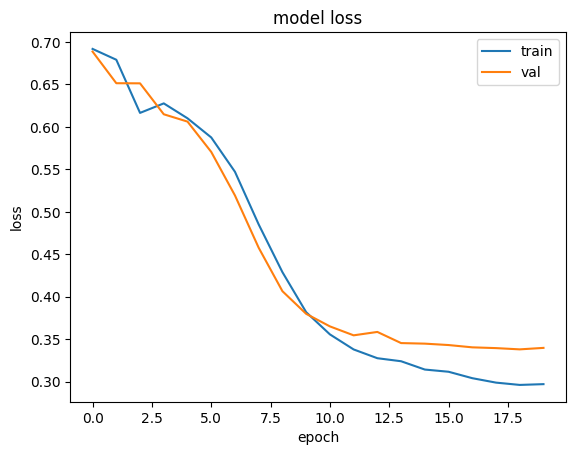

In [17]:
# Visualize the loss of training and validation over time
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.legend(['train', 'val'], loc = 'upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

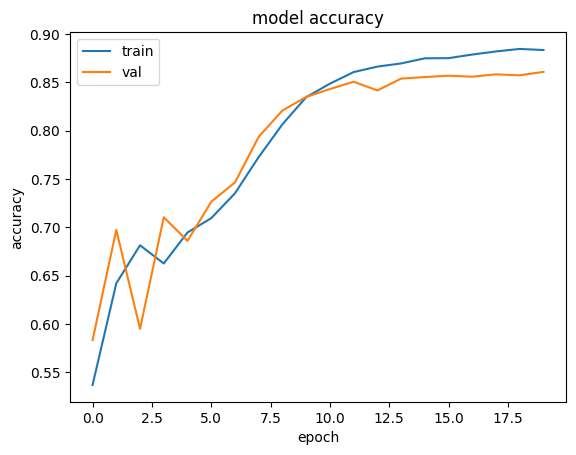

In [18]:
# Visualize the accuracy of training and validation over time
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [20]:
# Evaluate on the test set
test_loss, test_accuracy = lstm.evaluate(X_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

782/782 [==============================] - 12s 15ms/step - loss: 0.3345 - accuracy: 0.8595
Test loss:  0.3345392048358917
Test accuracy:  0.8594800233840942


## 2. RNN model with GRU

### Build the model: using GRU

In [ ]:
# Initialize sequential model with GRU layer
gru_model = tf.keras.models.Sequential([
    text_encoder,
    Embedding(
        input_dim = len(text_encoder.get_vocabulary()) + 1,
        output_dim = 64,
        mask_zero = True),
    GRU(units=64),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
# Summarize the model
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          64064     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,249
Trainable params: 93,249
Non-trainable params: 0
__________________________________________________

In [ ]:
# Check if the layers after Embedding layer supporting masking
print([layer.supports_masking for layer in gru_model.layers])

[False, True, True, True, True]


### Train the model

In [ ]:
gru_model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-3), 
              metrics = ['accuracy'])

gru_history = gru_model.fit(X_train, y_train, epochs = 20, batch_size = 2048, validation_data = (X_val, y_val))

Epoch 1/20
10/10 [==============================] - 16s 601ms/step - loss: 0.6924 - accuracy: 0.5134 - val_loss: 0.6910 - val_accuracy: 0.5748
Epoch 2/20
10/10 [==============================] - 3s 319ms/step - loss: 0.6871 - accuracy: 0.5910 - val_loss: 0.6819 - val_accuracy: 0.6076
Epoch 3/20
10/10 [==============================] - 3s 290ms/step - loss: 0.6662 - accuracy: 0.6372 - val_loss: 0.6455 - val_accuracy: 0.6456
Epoch 4/20
10/10 [==============================] - 3s 286ms/step - loss: 0.5916 - accuracy: 0.7022 - val_loss: 0.6016 - val_accuracy: 0.6572
Epoch 5/20
10/10 [==============================] - 4s 366ms/step - loss: 0.5664 - accuracy: 0.7009 - val_loss: 0.5738 - val_accuracy: 0.7014
Epoch 6/20
10/10 [==============================] - 3s 317ms/step - loss: 0.5383 - accuracy: 0.7308 - val_loss: 0.5351 - val_accuracy: 0.7256
Epoch 7/20
10/10 [==============================] - 3s 294ms/step - loss: 0.4987 - accuracy: 0.7567 - val_loss: 0.4782 - val_accuracy: 0.7774
Epoch

### Evaluate the model using GRU 

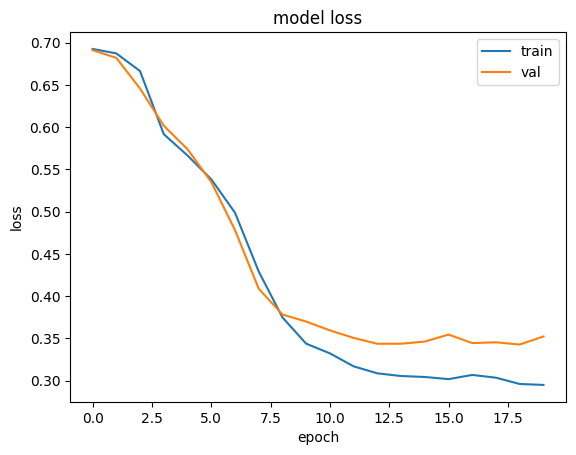

In [ ]:
# Visualize the loss of training and validation over time
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.legend(['train', 'val'], loc = 'upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

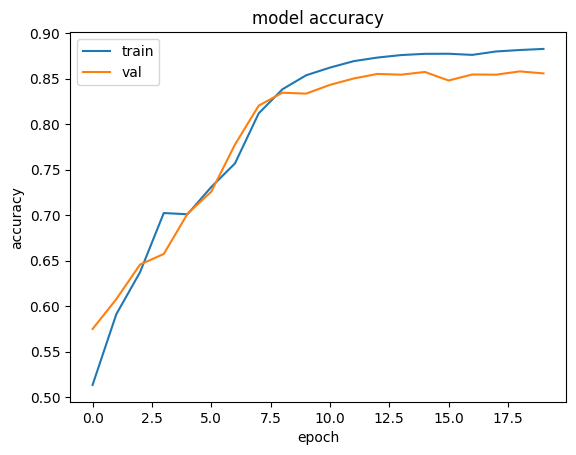

In [ ]:
# Visualize the loss of training and validation over time
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = gru_model.evaluate(X_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3410 - accuracy: 0.8573
Test loss:  0.3410199284553528
Test accuracy:  0.8572800159454346


In [ ]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
predictions = gru_model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 1s 1s/step
[0.68902296]
[0.31681335]


##3. RNN model with Bi-LSTM

### Build the model

In [22]:
# Initialize RNN model with Bidirectional LSTM layer
bi_model = tf.keras.models.Sequential([
    text_encoder,
    Embedding(
        input_dim = len(text_encoder.get_vocabulary()) + 1,
        output_dim = 64,
        mask_zero = True),
    Bidirectional(layer = LSTM(units = 64)),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    ])

# Summarize model
bi_model.summary()

# Check layer masking
print([layer.supports_masking for layer in bi_model.layers])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,433
Trainable params: 138,433
Non-tr

### Train the model

In [23]:
# Compile the model
bi_model.compile(loss = 'binary_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(1e-3),
                 metrics = ['accuracy'])
# Train the model
bi_history = bi_model.fit(X_train, y_train, epochs = 10, batch_size = 1024, validation_data = (X_val, y_val))

Epoch 1/10
20/20 [==============================] - 17s 397ms/step - loss: 0.6883 - accuracy: 0.5639 - val_loss: 0.6642 - val_accuracy: 0.6662
Epoch 2/10
20/20 [==============================] - 5s 259ms/step - loss: 0.5960 - accuracy: 0.7026 - val_loss: 0.5180 - val_accuracy: 0.7776
Epoch 3/10
20/20 [==============================] - 5s 254ms/step - loss: 0.4420 - accuracy: 0.8106 - val_loss: 0.3847 - val_accuracy: 0.8374
Epoch 4/10
20/20 [==============================] - 8s 429ms/step - loss: 0.3464 - accuracy: 0.8535 - val_loss: 0.3446 - val_accuracy: 0.8534
Epoch 5/10
20/20 [==============================] - 7s 365ms/step - loss: 0.3142 - accuracy: 0.8701 - val_loss: 0.3468 - val_accuracy: 0.8544
Epoch 6/10
20/20 [==============================] - 6s 306ms/step - loss: 0.3049 - accuracy: 0.8751 - val_loss: 0.3314 - val_accuracy: 0.8648
Epoch 7/10
20/20 [==============================] - 7s 359ms/step - loss: 0.3043 - accuracy: 0.8755 - val_loss: 0.3305 - val_accuracy: 0.8636
Epoch

### Evaluate the model using Bi-directional

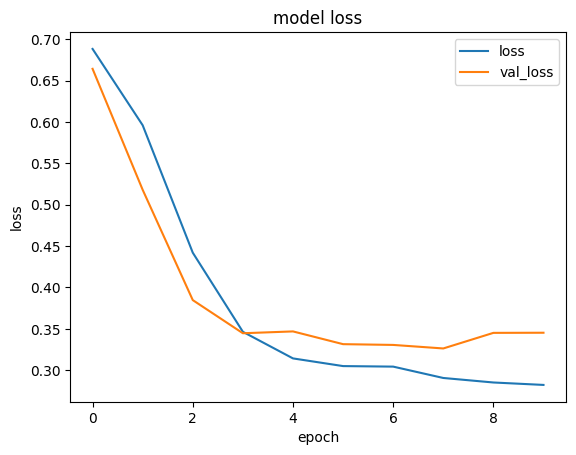

In [24]:
# Visualize the training and validation loss over epochs
plt.plot(bi_history.history['loss'])
plt.plot(bi_history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

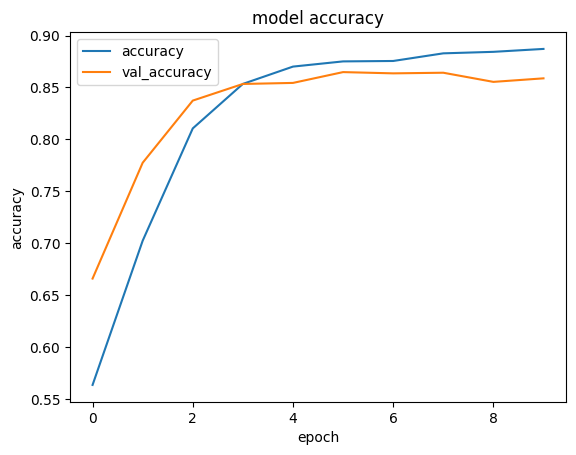

In [26]:
# Visualize the training and validation accuracy over epochs
plt.plot(bi_history.history['accuracy'])
plt.plot(bi_history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc = 'upper left')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = bi_model.evaluate(X_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

782/782 [==============================] - 17s 22ms/step - loss: 0.3420 - accuracy: 0.8593
Test loss:  0.3420022130012512
Test accuracy:  0.859279990196228


In [ ]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
bi_predictions = bi_model.predict(np.array(sample_reviews))
print(bi_predictions[0])
print(bi_predictions[1])

## 4. RNN Model using 1D Conv

### Build the model

In [ ]:
# Initialize sequential model with Conv1D layer
conv_model = tf.keras.models.Sequential([
    text_encoder,
    Embedding(
        input_dim = len(text_encoder.get_vocabulary()) + 1,
        output_dim = 64,
        mask_zero = True),
    Conv1D(filters = 16, kernel_size = 3, activation = 'relu'),
    MaxPooling1D(pool_size = 3),
    tf.keras.layers.GlobalMaxPooling1D(),
    # Flatten,
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
# Summarize model
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64064     
                                                                 
 conv1d_6 (Conv1D)           (None, None, 16)          3088      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                      

### Train the model

In [ ]:
conv_model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-3), 
              metrics = ['accuracy'])

conv_history = conv_model.fit(X_train, y_train, epochs = 10, batch_size = 512, validation_data = (X_val, y_val))

Epoch 1/10
40/40 [==============================] - 14s 306ms/step - loss: 0.6832 - accuracy: 0.6216 - val_loss: 0.6540 - val_accuracy: 0.7406
Epoch 2/10
40/40 [==============================] - 5s 136ms/step - loss: 0.5716 - accuracy: 0.7786 - val_loss: 0.4716 - val_accuracy: 0.7864
Epoch 3/10
40/40 [==============================] - 4s 107ms/step - loss: 0.4115 - accuracy: 0.8197 - val_loss: 0.3868 - val_accuracy: 0.8252
Epoch 4/10
40/40 [==============================] - 3s 84ms/step - loss: 0.3465 - accuracy: 0.8512 - val_loss: 0.3562 - val_accuracy: 0.8454
Epoch 5/10
40/40 [==============================] - 4s 92ms/step - loss: 0.3049 - accuracy: 0.8741 - val_loss: 0.3434 - val_accuracy: 0.8522
Epoch 6/10
40/40 [==============================] - 2s 60ms/step - loss: 0.2728 - accuracy: 0.8899 - val_loss: 0.3399 - val_accuracy: 0.8570
Epoch 7/10
40/40 [==============================] - 3s 68ms/step - loss: 0.2452 - accuracy: 0.9042 - val_loss: 0.3423 - val_accuracy: 0.8554
Epoch 8/1

### Evaluate the model

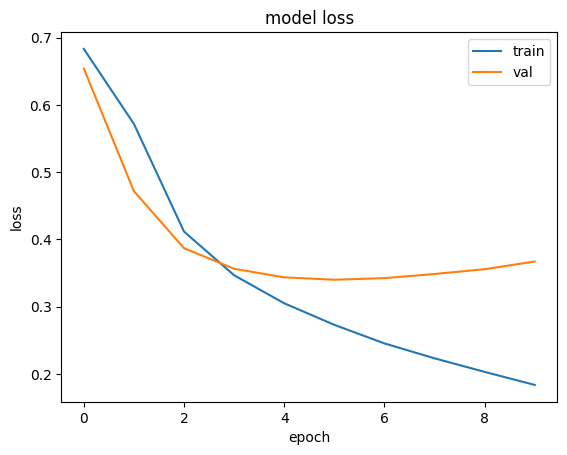

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

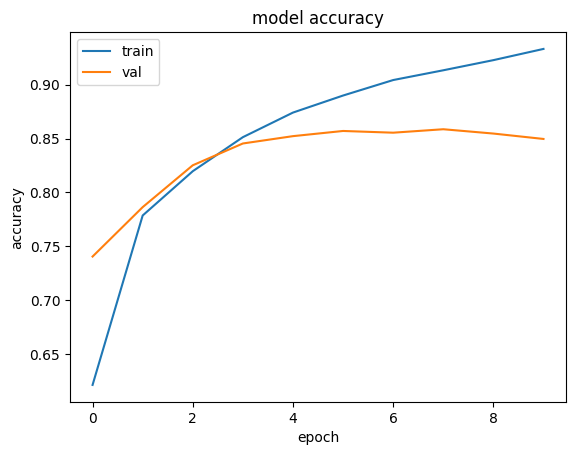

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(conv_history.history['accuracy'])
plt.plot(conv_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
conv_test_loss, conv_test_acc = conv_model.evaluate(X_test, y_test)
print('Test Loss:', conv_test_loss)
print('Test Accuracy:', conv_test_acc)

782/782 [==============================] - 13s 16ms/step - loss: 0.3635 - accuracy: 0.8480
Test Loss: 0.3635491728782654
Test Accuracy: 0.8479999899864197


## 5. GloVe

### Convert vocabulary indices with pre-trained GloVe vector

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip  
!unzip glove.6B.zip 

--2023-05-10 11:00:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-10 11:00:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-10 11:00:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Creating a dictionary mapping words in vocabulary with their indices
word_index = dict(zip(vocab, range(len(vocab))))
word_index["the"]

2

In [ ]:
# Choosing 100-dimensional text-encoded vectors
glove_path = "glove.6B.100d.txt"

# Creating a dictionary mapping words to their NumPy vector from pre-trained GloVe word vectors
embedding_index = {}
with open(glove_path) as f:
  for line in f:
    word, vector = line.split(maxsplit = 1)
    vector = np.fromstring(vector, "f", sep = " ") # Convert string to 1D array
    embedding_index[word] = vector

embedding_index["the"]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [ ]:
# Creating an embedding matrix mapping the index of word in vocabulary
# with the pre-trained its corresponding vector
embedding_dim = 100
hits = 0
misses = 0
num_tokens = VOCAB_SIZE + 2

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits+=1
  else:
    misses +=1

print("Converted %d words (missed %d words)" % (hits, misses))

Converted 993 words (missed 7 words)


### Build the model

In [ ]:
# Creating embedding layer
embedding_layer = Embedding(
    input_dim = num_tokens,
    output_dim = embedding_dim,
    # Generate tensor with constant values
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False,
    mask_zero = True
)

In [ ]:
glove_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100200    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 64)                6464      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 187,129
Trainable params: 86,929
Non-trainable params: 100,200
_________________________________________________________________


In [ ]:
from tensorflow.keras import layers, models

int_sequences_input = layers.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = LSTM(units=100)(embedded_sequences)
x = Dense(64, activation = 'relu')(x)
preds = Dense(1, activation = 'sigmoid')(x)
glove_model = models.Model(int_sequences_input, preds)
glove_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         100200    
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_13 (Dense)            (None, 64)                6464      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 187,129
Trainable params: 86,929
Non-trainable params: 100,200
_________________________________________________________________


### Train the model

In [ ]:
X_train_glove = text_encoder(np.array([[s] for s in X_train])).numpy()
X_val_glove = text_encoder(np.array([[s] for s in X_val])).numpy()
X_test_glove = text_encoder(np.array([[s] for s in X_test])).numpy()

y_train_glove = np.array(y_train)
y_val_glove = np.array(y_val)
y_test_glove = np.array(y_test)

In [ ]:
# Compile the model
glove_model.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

# Train the model
glove_history = glove_model.fit(X_train_glove, y_train_glove, epochs=20, batch_size = 1024, validation_data=(X_val_glove, y_val_glove)) # Here the test dataset is used as validtion set

Epoch 1/20
20/20 [==============================] - 11s 269ms/step - loss: 0.6751 - accuracy: 0.5694 - val_loss: 0.6500 - val_accuracy: 0.6206
Epoch 2/20
20/20 [==============================] - 4s 201ms/step - loss: 0.6081 - accuracy: 0.6700 - val_loss: 0.5913 - val_accuracy: 0.6884
Epoch 3/20
20/20 [==============================] - 4s 214ms/step - loss: 0.5572 - accuracy: 0.7228 - val_loss: 0.5140 - val_accuracy: 0.7530
Epoch 4/20
20/20 [==============================] - 4s 185ms/step - loss: 0.5283 - accuracy: 0.7423 - val_loss: 0.5025 - val_accuracy: 0.7580
Epoch 5/20
20/20 [==============================] - 4s 184ms/step - loss: 0.5154 - accuracy: 0.7530 - val_loss: 0.4930 - val_accuracy: 0.7622
Epoch 6/20
20/20 [==============================] - 4s 211ms/step - loss: 0.5073 - accuracy: 0.7536 - val_loss: 0.5567 - val_accuracy: 0.7252
Epoch 7/20
20/20 [==============================] - 4s 199ms/step - loss: 0.5008 - accuracy: 0.7614 - val_loss: 0.5302 - val_accuracy: 0.7310
Epoch

### Evaluate the model

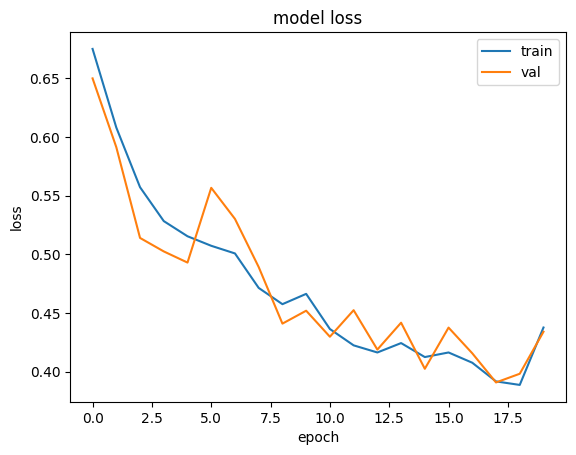

In [ ]:
# Visualize the training and validation loss over epochs
plt.plot(glove_history.history['loss'])
plt.plot(glove_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

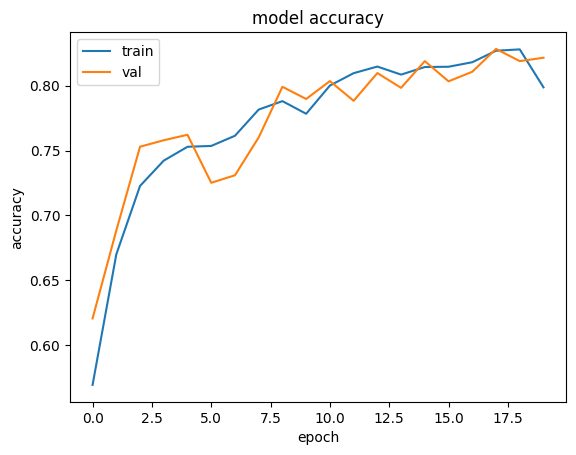

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(glove_history.history['accuracy'])
plt.plot(glove_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set

glove_test_loss, glove_test_acc = glove_model.evaluate(X_test_glove, y_test_glove)
print('Test Loss:', glove_test_loss)
print('Test Accuracy:', glove_test_acc)

782/782 [==============================] - 12s 14ms/step - loss: 0.4380 - accuracy: 0.8168
Test Loss: 0.4379879832267761
Test Accuracy: 0.8167999982833862


## Comparison

Accuracy:
- Model with LSTM layer and Bidirectional LSTM have quite similar accuracy score (0.859), which is also the highest
- Model with GRU layer is quite lower but still > 85%, followed by Conv1D with > 84% accuracy score
- Surprisingly, RNN model using pre-trained GloVe vector representing for each word performed worst, with only 81% accuracy

Fluctuation:
- RNN model with GloVe is very fluctating during training process